In [35]:
import sys
import os

# プロジェクトルートをsys.pathに追加
project_root = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH set to:", project_root)

PYTHONPATH set to: c:\Users\ndhaj\Desktop\TCI


In [36]:
# =============================
# [0] 共通Importと初期化
# =============================
from ptychoep.backend.backend import set_backend, np
set_backend("numpy")
from matplotlib import pyplot as plt
from ptychoep.ptycho.core import Ptycho
from ptychoep.utils.io_utils import load_data_image
from ptychoep.ptycho.aperture_utils import circular_aperture
from ptychoep.ptycho.scan_utils import generate_spiral_scan_positions, generate_centered_grid_positions
from ptychoep.ptycho.noise import GaussianNoise, PoissonNoise
from ptychoep.ptycho.visualize import compute_illumination
from ptychoep.rng.rng_utils import get_rng
from ptychoep.classic_engines.pie import PIE
from ptychoep.ptychoep.core import PtychoEP

def show_reconstruction(obj, probe, title=""):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.title(f"{title}: Amplitude (Object)")
    plt.imshow(np().abs(obj), cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"{title}: Phase (Object)")
    plt.imshow(np().angle(obj), cmap="twilight")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"{title}: Amplitude (Probe)")
    plt.imshow(np().abs(probe), cmap="gray")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# ------------------ 再構成対象データ準備 ------------------
image_size = 512
probe_size = 128
step = 18
num_scans = 11
jitter = 2

# オブジェクト
amp = np().asarray(load_data_image("cameraman.png"), dtype=np().complex64)
phase = np().asarray(load_data_image("eagle.png"), dtype=np().complex64)
obj = amp * np().exp(1j * np().pi/2 * phase)

# 初期プローブ
probe_gt = np().array(load_data_image("probe.png") , dtype=np().complex64)
probe_init = np().array(load_data_image("probe_init.png"), dtype=np().complex64)

# スキャン座標
positions = generate_centered_grid_positions(
    image_size=image_size,
    probe_size=probe_size,
    step=step,
    num_points_y=num_scans,
    num_points_x=num_scans,
    jitter=jitter,
    seed=90
)
data_seed = 124
# Ptychoオブジェクト
ptycho = Ptycho()
ptycho.set_object(obj)
ptycho.set_probe(probe_gt)
ptycho.forward_and_set_diffraction(positions)
ptycho.sort_diffraction_data()
#scale = 3000
var = 1e-4
#PoissonNoise(scale = scale, seed=data_seed) @ ptycho
GaussianNoise(var = var, seed = data_seed) @ ptycho
print(f" {len(ptycho._diff_data)}\n Noise Stats : {ptycho.noise_stats}")
max_count = [np().max(diff.diffraction) for diff in ptycho._diff_data]
print(f"maximum number of photons :  {np().max(np().array(max_count)) ** 2 * scale - 3./8.}")

 121
 Noise Stats : {'type': 'Gaussian', 'var': 0.0001, 'snr_mean_db': 13.874597549438477}
maximum number of photons :  107349.2890625


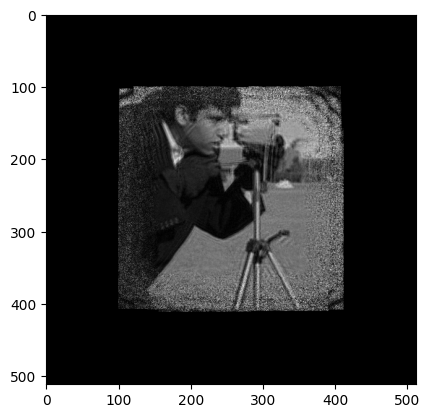

In [37]:
from ptychoep.ptychoep.core import PtychoEP

ep_list = []
def record_callback(it, err, current_obj):
        ep_list.append(err)

engine = PtychoEP(ptycho = ptycho,
                  prb_init = probe_init,
                  damping = 0.9,
                  n_probe_update = 2,
                  seed = 1, 
                  callback = record_callback)
result_ep = engine.run(n_iter = 100)
plt.imshow(np().abs(result_ep[0]), cmap = "gray")

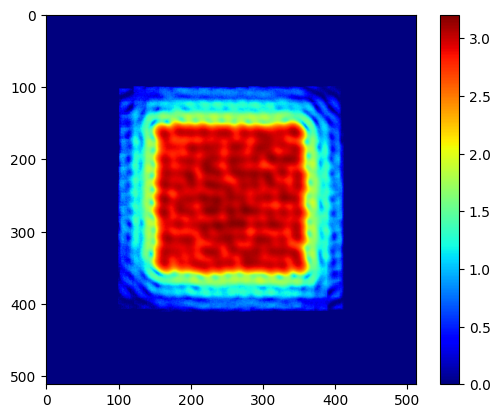

In [46]:
plt.imshow(np().log10(result_ep[1]), cmap = "jet")
plt.colorbar()

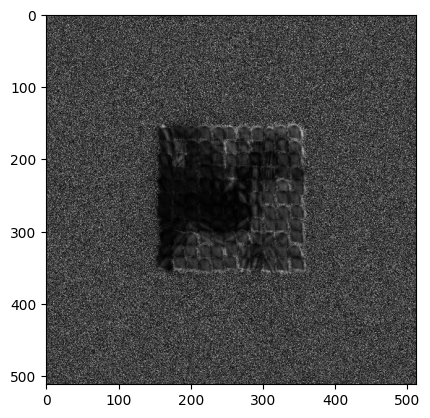

In [38]:
from ptychoep.classic_engines.epie import ePIE

epie_list = []
def record_callback(it, err, current_obj):
        epie_list.append(err)

engine = ePIE(ptycho = ptycho,
                alpha = 1.0, 
                beta = 1.0,
                prb_init = probe_init,
                callback = record_callback,
                seed = 12)
result_epie = engine.run(n_iter = 200)
plt.imshow(np().abs(result_epie[0]), cmap = "gray")

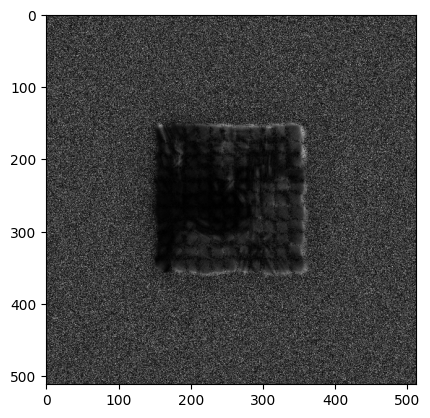

In [39]:
from ptychoep.classic_engines.rpie import rPIE

rpie_list = []
def record_callback(it, err, current_obj):
        rpie_list.append(err)

engine = rPIE(ptycho = ptycho,
                alpha = 0.1, 
                beta = 1.0,
                prb_init = probe_init,
                callback = record_callback,
                seed = 13)
result_rpie = engine.run(n_iter = 200)
plt.imshow(np().abs(result_rpie[0]), cmap = "gray")

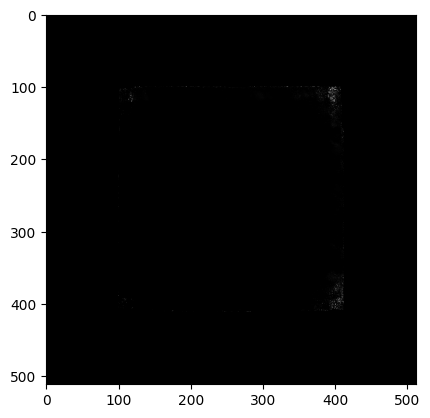

In [40]:
from ptychoep.classic_engines.difference_map import DifferenceMap

dm_list = []
def record_callback(it, err, current_obj):
        dm_list.append(err)

engine = DifferenceMap(ptycho = ptycho,
                  prb_init = probe_init,
                  callback = record_callback,
                  seed = 125)
result_dm = engine.run(n_iter = 100)
plt.imshow(np().abs(result_dm[0]), cmap = "gray")

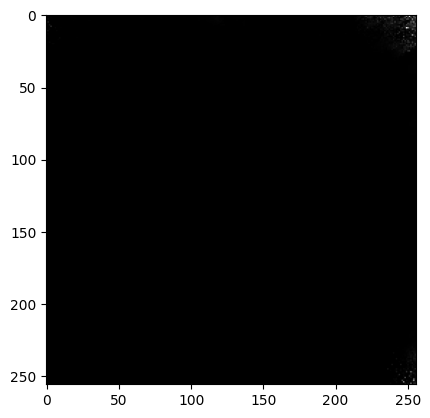

In [41]:
plt.imshow(np().abs(result_dm[0])[128:384, 128:384], cmap = "gray")

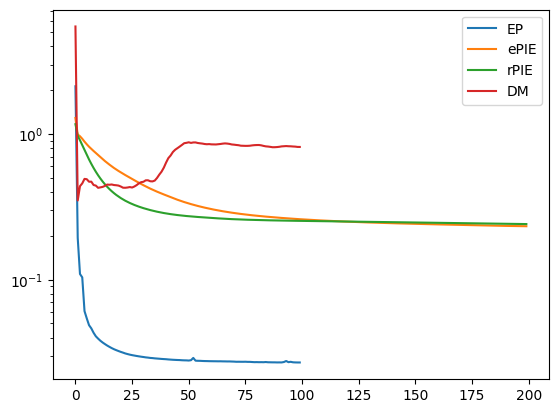

In [42]:
#normalize
diff_power = [np().mean(np().abs(diff.diffraction)**2) for diff in ptycho._diff_data]
diff_power = np().mean(diff_power)

ep_array = np().asarray(ep_list)/diff_power
epie_array = np().asarray(epie_list)/diff_power
rpie_array = np().asarray(rpie_list)/diff_power
dm_array = np().asarray(dm_list)/diff_power

plt.plot(ep_array, label = "EP")
plt.plot(epie_array, label = "ePIE")
plt.plot(rpie_array, label = "rPIE")
plt.plot(dm_array, label = "DM")
plt.yscale('log')
plt.legend()

In [43]:
diff_power

np.float32(0.0041477834)